# GANs in PyTORCH

In this notebook, I have referred to a PyTorch tutorial by FreeCodeCamp on YouTube.

The course was on PyTorch - Beginner to GANs


## 1. Setup the data

MNIST Dataset

### 1.1 Import Libraries and Download the Data

In [18]:
import torch
import torchvision

In [8]:
# Setup training data 
from torchvision.datasets import MNIST 
from torchvision.transforms import ToTensor, Normalize, Compose


mnist = MNIST(root="data", 
              train=True, 
              download=True, 
              transform=Compose([ToTensor(), Normalize(mean=(0.5,),std=(0.5,))]))

In [9]:
img, label = mnist[0]
print('Label:', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [10]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Print an image from the dataset

Text(0.5, 1.0, 'Label: 5')

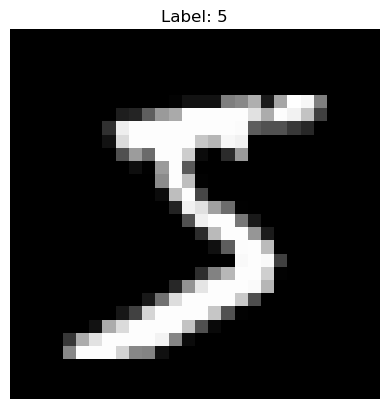

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# img_norm = denorm(img)
img_norm = img
plt.imshow(img_norm[0], cmap='gray')
plt.axis('off')
plt.title('Label: ' + str(label))
# print('Label:', label)

### 1.2 Convert the data to DataLoader

In [16]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

### 1.3 Assign Device

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device
device

'mps'

## 2. Create the Discriminator

The Discriminator is a simple classifier that takes an image as input and classifies it as real or fake.

In [17]:
image_size = 28*28
hidden_size = 256

In [47]:
import torch.nn as nn

discriminator = nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )

In [48]:
# Move the discriminator model to the chosen device
discriminator.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## 3. Create the Generator

The Generator takes a random noise as input and generates an image.

In [21]:
latent_size = 64

In [46]:
generator = nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh()
    )

In [49]:
# Move the generator model to the chosen device
generator.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [27]:
random_input = torch.randn(2, latent_size).to(device)
random_input

tensor([[-0.4920,  1.1420,  1.2547,  0.6874, -0.8721,  1.4639,  0.5926,  0.7685,
         -0.0406,  1.2729,  0.0859, -1.6769, -1.5871, -1.5428,  0.6521, -1.6089,
          0.7265,  0.0215,  0.2043,  0.2661, -1.4474,  1.1162, -0.0916, -0.6123,
         -1.3919,  0.1327,  0.5361,  0.7462, -1.7970,  1.1158, -0.0160,  0.3895,
         -0.4829,  1.5592,  0.0725,  0.8886,  0.3742, -1.0955, -2.3393, -1.2049,
         -0.7698,  0.7678, -0.6575,  0.0128, -2.2330, -0.2684,  0.7195,  1.0689,
         -1.0237,  0.1723,  0.2949,  1.5999, -0.5256, -0.6526, -0.5761,  0.9611,
          0.2907, -1.5251, -0.0629,  0.8719,  0.5239, -1.3284, -0.2336, -0.9587],
        [ 1.4378,  0.5076,  0.3251, -0.0829, -0.5370,  1.4230,  0.1603,  3.3183,
         -0.1358, -0.3720, -0.8908, -0.7376,  0.1859, -0.3102, -1.1959,  0.0232,
         -1.3424,  0.3005,  0.2258,  0.4000,  1.7524,  0.4005, -0.0094, -1.5084,
          0.9709, -1.5534, -0.1858, -1.2313, -0.6415, -0.0812, -0.3481,  0.9730,
          1.7302,  0.2905, 

In [26]:
y = generator(random_input) # Generate 2 random images
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())

In [29]:
y.shape, gen_imgs.shape

(torch.Size([2, 784]), torch.Size([2, 28, 28]))

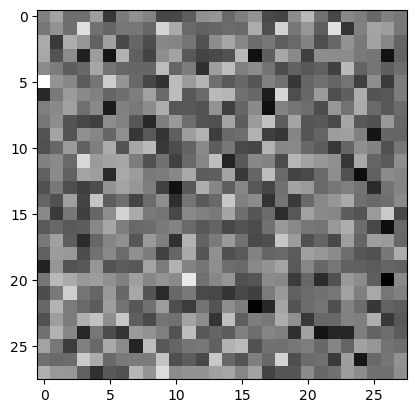

In [33]:
plt.imshow(gen_imgs[1].cpu(), cmap='gray')

## 4. Training the Discriminator

Since the discriminator is a binary classifier, we can use the binary cross-entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [51]:
# criterion = nn.BCELoss()
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

Let's define helper functions to reset the gradients and train the discriminator.

In [53]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [37]:
def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device) # real labels = 1
    fake_labels = torch.zeros(batch_size, 1).to(device) # fake labels = 0

    # Loss for real images
    outputs = discriminator(images) # images are the real images, so the output should be 1
    d_loss_real = criterion(outputs, real_labels) # the discriminator loss for real images  
    real_score = outputs # real_score is the output of the discriminator for real images

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device) # z is the random input to the generator
    fake_images = generator(z) # fake images are generated by the generator using the random input z
    
    outputs = discriminator(fake_images) # the output of the discriminator for fake images
    d_loss_fake = criterion(outputs, fake_labels) # the discriminator loss for fake images
    fake_score = outputs # fake_score is the output of the discriminator for fake images

    # Combine losses
    d_loss = d_loss_real + d_loss_fake # the total discriminator loss is the sum of the loss for real and fake images

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()
    
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

## 5. Training the Generator

The generator's objective is to confuse the discriminator into thinking that the generated images are real.

In [54]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device) # z is the random input to the generator
    fake_images = generator(z) # fake images are generated by the generator using the random input z
    labels = torch.ones(batch_size, 1).to(device) # since the generator wants to fool the discriminator, the labels are all 1
    g_loss = criterion(discriminator(fake_images), labels) # the generator loss is the loss of the discriminator for the fake images

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

## 6. Training the GAN

We'll define a helper function to train the discriminator and the generator.

In [55]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Save some real images

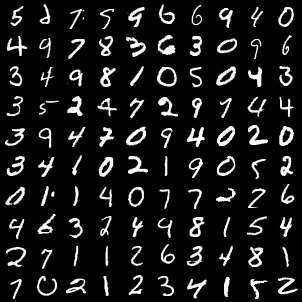

In [56]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Save a batch of generated images at the end of every epoch. 

We will use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


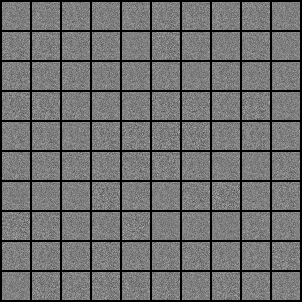

In [57]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)

Image(os.path.join(sample_dir, 'fake_images-0000.png'))

Now we train the GAN. During each epoch, we'll train the discriminator first, and then the generator.

In [58]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.0215, g_loss: 4.5271, D(x): 1.00, D(G(z)): 0.02
Epoch [0/100], Step [400/600], d_loss: 0.4015, g_loss: 4.1295, D(x): 0.86, D(G(z)): 0.15
Epoch [0/100], Step [600/600], d_loss: 0.0949, g_loss: 4.1089, D(x): 0.96, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.1895, g_loss: 3.7534, D(x): 0.95, D(G(z)): 0.11
Epoch [1/100], Step [400/600], d_loss: 0.1923, g_loss: 3.8129, D(x): 0.89, D(G(z)): 0.05
Epoch [1/100], Step [600/600], d_loss: 0.4972, g_loss: 4.2018, D(x): 0.88, D(G(z)): 0.19
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.6119, g_loss: 2.5946, D(x): 0.85, D(G(z)): 0.28
Epoch [2/100], Step [400/600], d_loss: 0.5107, g_loss: 3.8779, D(x): 0.85, D(G(z)): 0.21
Epoch [2/100], Step [600/600], d_loss: 0.2448, g_loss: 3.1590, D(x): 0.94, D(G(z)): 0.15
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.8552, g_loss: 3.8390, D(x): 0.70, D(G(z)): 0.13
Epoch [3/100], Step [400/6

## 7. Save the Models and Images

Save the models and some generated images to disk.

Now that the models are trained, we can save checkpoints and generate some images.

In [ ]:
# Save the model checkpoints 

# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # If exists, don't do anything

# 2. Create model save path
D_MODEL_NAME = "D.ckpt"
G_MODEL_NAME = "G.ckpt" 


# 3. Save the model state dict
MODEL_SAVE_PATH = MODEL_PATH / D_MODEL_NAME
print(f"Saving Discriminator state dict to: {MODEL_SAVE_PATH}")
torch.save(obj=discriminator.state_dict(), 
           f=MODEL_SAVE_PATH)

MODEL_SAVE_PATH = MODEL_PATH / G_MODEL_NAME
print(f"Saving Generator state dict to: {MODEL_SAVE_PATH}")
torch.save(obj=generator.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving Discriminator state dict to: models/D.ckpt
Saving Generator state dict to: models/G.ckpt


We can also visualize the training process by generating and saving sample images.

In [65]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/77/df/b56175c3fb5bc058774bdcf35f5a71cf9c3c5b909f98a1c688eb71cd3b1f/opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 12.3 MB/s eta 0:00:0000:0100:01


In [66]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()
files

['samples/fake_images-0000.png',
 'samples/fake_images-0001.png',
 'samples/fake_images-0002.png',
 'samples/fake_images-0003.png',
 'samples/fake_images-0004.png',
 'samples/fake_images-0005.png',
 'samples/fake_images-0006.png',
 'samples/fake_images-0007.png',
 'samples/fake_images-0008.png',
 'samples/fake_images-0009.png',
 'samples/fake_images-0010.png',
 'samples/fake_images-0011.png',
 'samples/fake_images-0012.png',
 'samples/fake_images-0013.png',
 'samples/fake_images-0014.png',
 'samples/fake_images-0015.png',
 'samples/fake_images-0016.png',
 'samples/fake_images-0017.png',
 'samples/fake_images-0018.png',
 'samples/fake_images-0019.png',
 'samples/fake_images-0020.png',
 'samples/fake_images-0021.png',
 'samples/fake_images-0022.png',
 'samples/fake_images-0023.png',
 'samples/fake_images-0024.png',
 'samples/fake_images-0025.png',
 'samples/fake_images-0026.png',
 'samples/fake_images-0027.png',
 'samples/fake_images-0028.png',
 'samples/fake_images-0029.png',
 'samples/

In [67]:
out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


/Users/hannan/Desktop/Uni/Learn_PyTorch/gans_training.avi

## 8. Plot curves

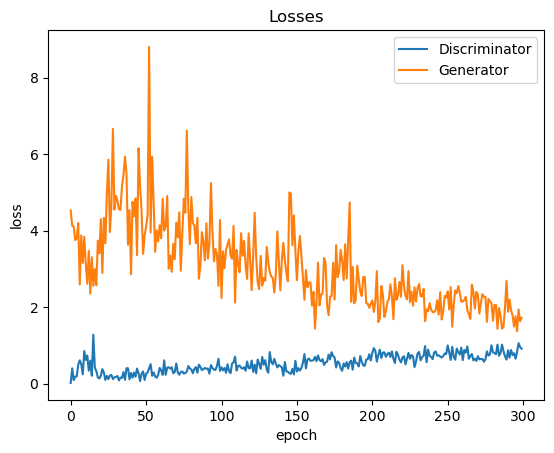

In [68]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

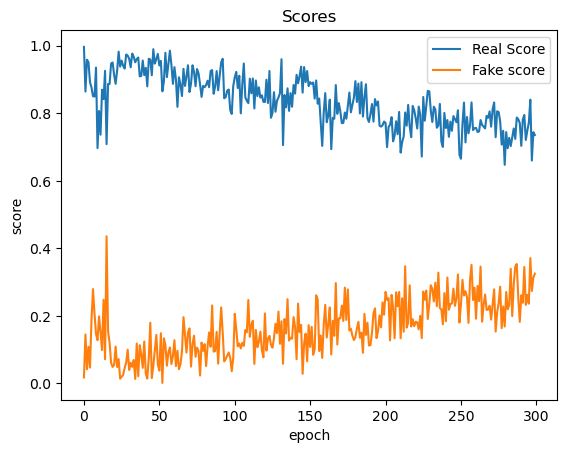

In [69]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');